### Import required  python modules

##### trimesh 
This module is needed to convert an .stl file into a voxelized matrix

##### poreSpy
This module contains a lot of filters and metric functions for analysis of porous media, starting with a voxelized metric 

In [1]:
import pyglet
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import porespy as ps
import scipy.ndimage as spim
import skimage

### Import the mesh file

30 PPI Ceramic sample

In [2]:
mesh=trimesh.load_mesh('foam_ppi_50_scaled.stl')

Check if water-tight

In [3]:
mesh.is_watertight

False

### Voxelize the .stl file

**pitch**: is the size of the voxel (in absolute units), ex.: `pitch=0.001` the voxel size is 0.001 m

This procedure can be very time and memory consuming

In [4]:
volume=mesh.voxelized(pitch=0.00005).fill(method='holes') 

Save the mesh into a numpy matrix --> 0: Fluid, 1: Solid

In [5]:
mat=volume.matrix
np.save('30PPI.npy', mat)

Get the matrix size for each direction, namely the number of voxel

In [6]:
print('Voxel_x:',mat.shape[0])
print('Voxel_y:',mat.shape[1])
print('Voxel_z:',mat.shape[2])

Voxel_x: 649
Voxel_y: 647
Voxel_z: 226


Print a slice of the geometry

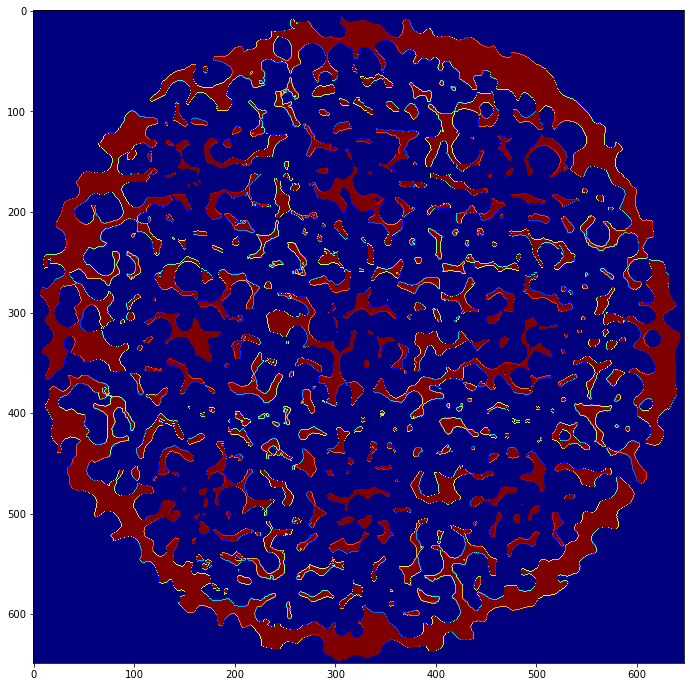

In [7]:
fig=plt.figure(figsize=(12,12))
fig = plt.imshow(mat[:,:,113], cmap=plt.cm.jet)
plt.savefig('prova3_slice.png', )

Determine the slice size in **x,y** direction

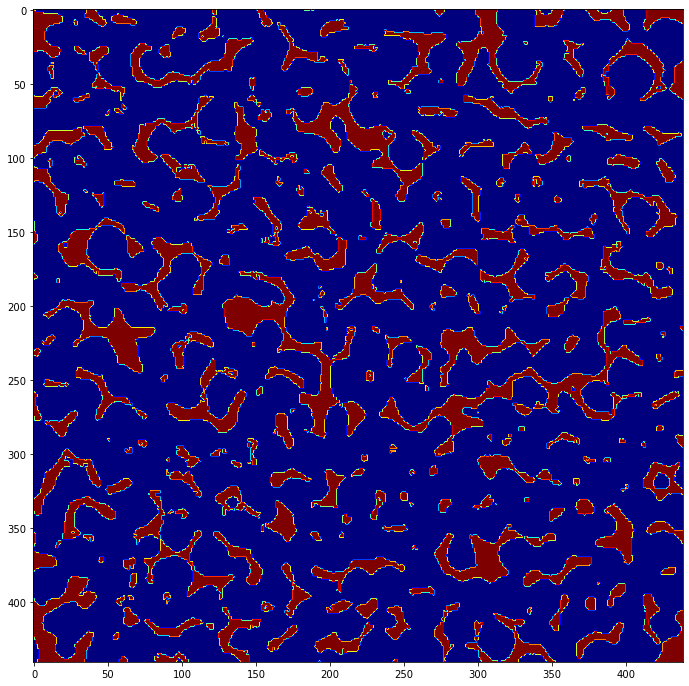

In [9]:
slc=104

fig=plt.figure(figsize=(12,12))
fig = plt.imshow(mat[slc:-slc,slc:-slc,113], cmap=plt.cm.jet)
plt.savefig('prova3_slice.png', )

### Geometry analysis  with PoreSpy

PoreSpy require the that the matrix representing the voxelized version of the .stl to have 0 for the solid and 1 for the fluid

In [10]:
im = mat[slc:-slc,slc:-slc,:]
im=np.logical_not(im)

the function `local_thickness` do the following:
*For each voxel, this function calculates the radius of the largest sphere that both engulfs the voxel and fits entirely within the foreground.*

In [11]:
thk = ps.filters.local_thickness(im, sizes= 300,mode='dt')

100%|██████████| 300/300 [14:04<00:00,  2.82s/it]


Plot the entire mesh

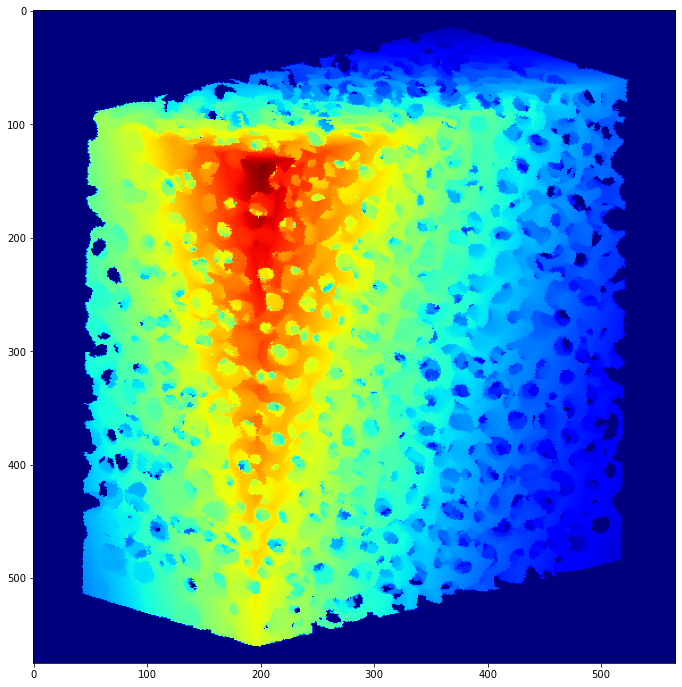

In [12]:
plt.figure(figsize=[12, 12])
plt.imshow(ps.visualization.show_3D(thk.astype(np.bool)), cmap=plt.cm.jet)


Plot the spheres fitted inside the structure 

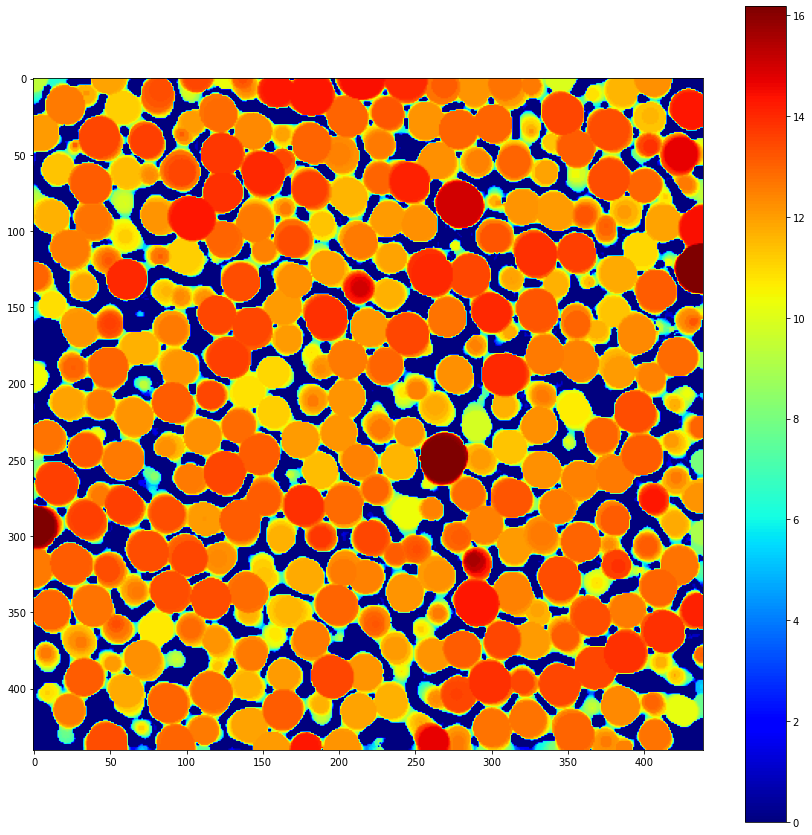

In [16]:
fig, ax1 = plt.subplots(figsize=(15, 15))
pos = ax1.imshow(thk[:,:,100], cmap=plt.cm.jet)
fig.colorbar(pos,ax=ax1)


Calculate the porosity of the sample

In [17]:
print('Porosity=',ps.metrics.porosity(im=im))


Porosity= 0.7631765723941656


Calculate the pore size distribution with the function `metrics.pore_size_distribution()`. It is possible to set the number of *bins*

In [18]:
psd = ps.metrics.pore_size_distribution(im=thk,bins=20)

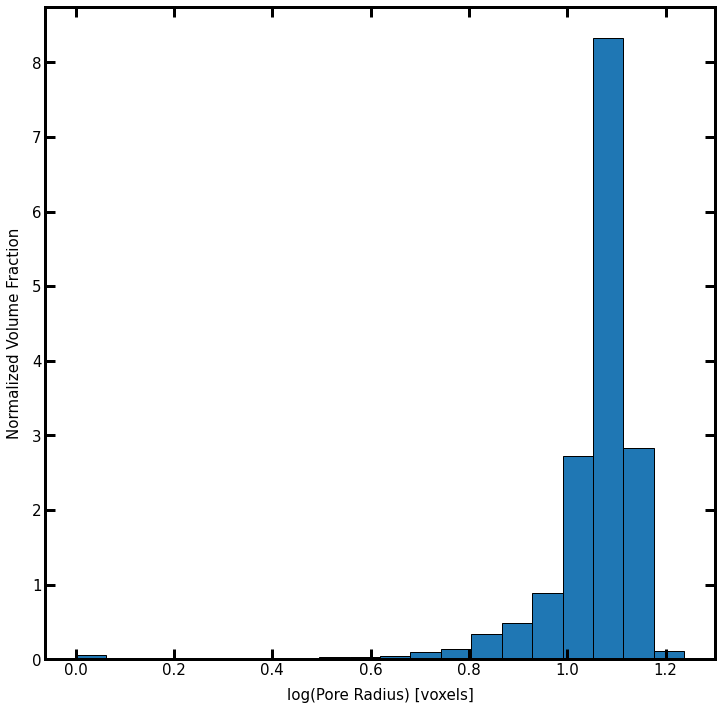

In [19]:
ps.visualization.set_mpl_style()
plt.figure(figsize=[12, 12])
plt.xlabel('log(Pore Radius) [voxels]')
plt.ylabel('Normalized Volume Fraction')
fig = plt.bar(x=psd.logR, height=psd.pdf, width=psd.bin_widths, edgecolor='k')
plt.show()

There is also the possibility to make an analysis on the *REV* 

In [20]:
profile = ps.metrics.representative_elementary_volume(im=im)

100%|██████████| 1000/1000 [00:02<00:00, 383.88it/s]


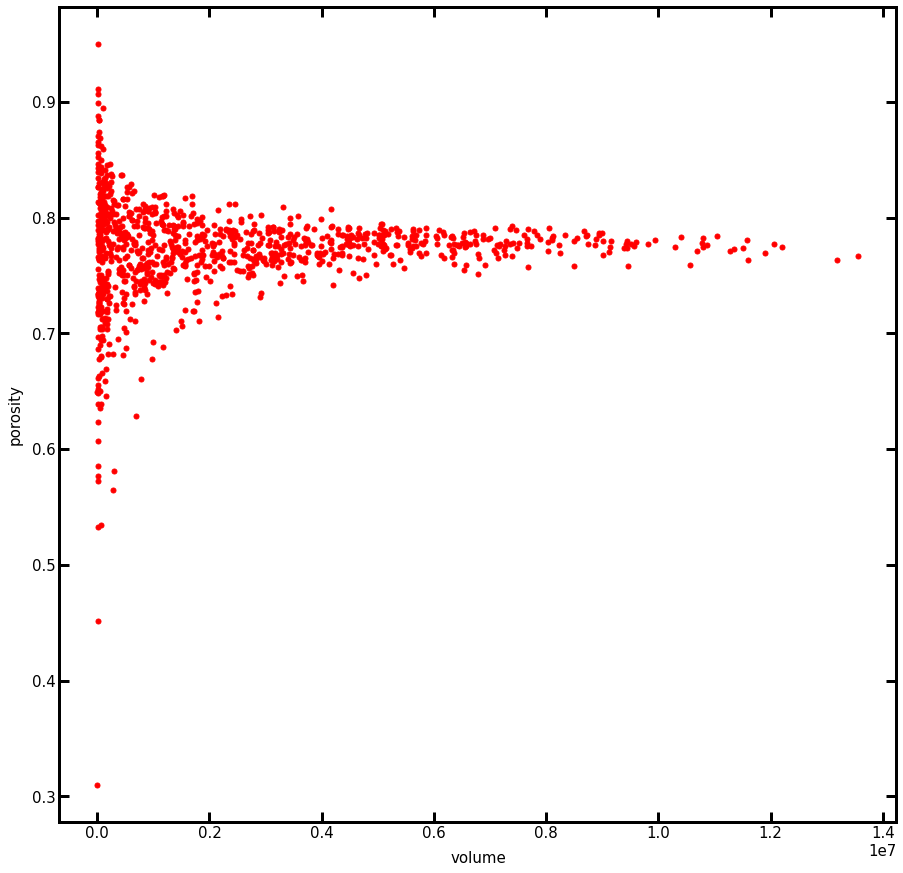

In [22]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(profile.volume, profile.porosity, 'r.')
ax.set_xlabel("volume")
ax.set_ylabel("porosity");

There is also the possibility to make an analysis on the *two-points autocorrelation* 

In [23]:
x = ps.metrics.two_point_correlation_fft(im=im)

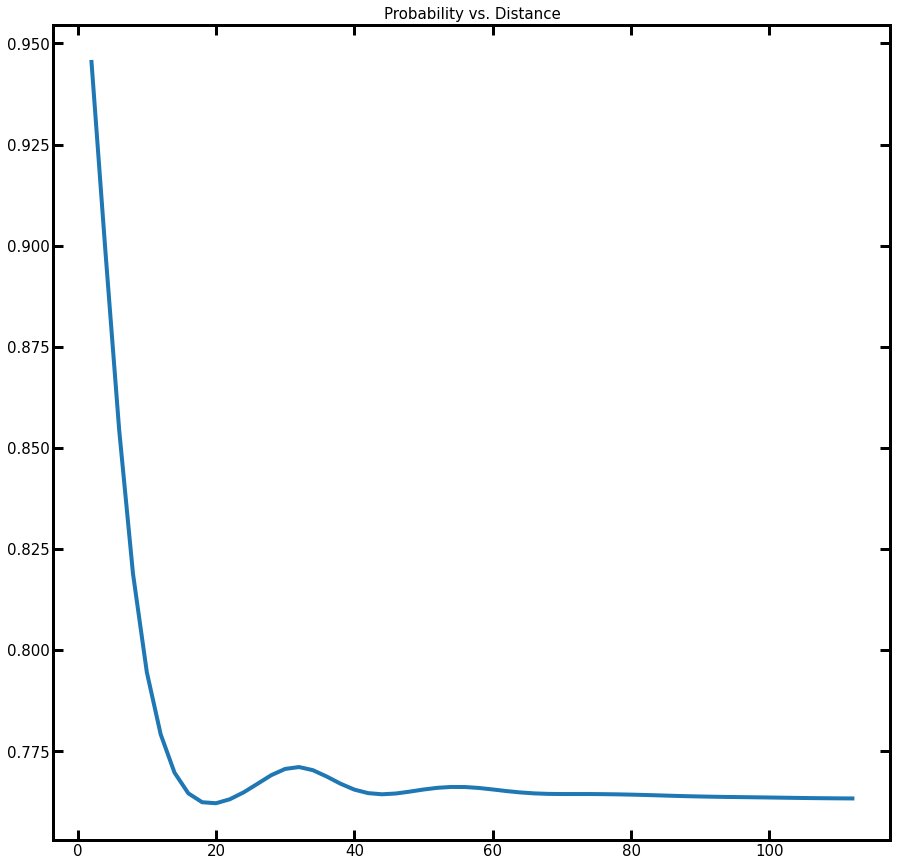

In [24]:
plt.figure(figsize=(15, 15))
plt.title("Probability vs. Distance")
plt.plot(x.distance, x.probability)
plt.show();

Many other features on metrics and filters are available. Check at https://porespy.org/modules/index.html

Save the VTK file of the spheres inflated in the foam to visualize them in *Paraview*

In [25]:
np.save('30PPI_ceramic.npy', thk)
ps.io.to_vtk(thk, '30PPI_ceramic', voxel_size=0.0001)